In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages
seed_value = 0
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from utils_measure import measure_thickness, get_cnt_idx_w_largest_area
from utils_stat_process import post_process

np.random.seed(seed_value)
random.seed(seed_value)


In [2]:
def stat_analysis(thick_media, thick_intima):
    thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])
    thick_media, thick_intima, _ = post_process(thick_media, thick_intima, thick_wall, 21, 11, 11, 21)
    return thick_media, thick_intima

In [3]:
def get_cnts(img):
    gray_r = img[:, :, 0].copy()
    gray_g = img[:, :, 1].copy()
    gray_b = img[:, :, 2].copy()

    contours_r, hierarchy = cv2.findContours(gray_r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_g, hierarchy = cv2.findContours(gray_g, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_b, hierarchy = cv2.findContours(gray_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_r = [x.reshape(-1, 2) for x in contours_r]
    contours_g = [x.reshape(-1, 2) for x in contours_g]
    contours_b = [x.reshape(-1, 2) for x in contours_b]
    # Separate the contours
    return contours_r, contours_g, contours_b

In [4]:
def cnt_polygon_test(cnt1, cnt2):
    cnt1 = cnt1.reshape(-1, 2)
    cnt2 = cnt2.reshape(-1, 2)
    # check if cnt1 inside/cross cnt2    
    for point in cnt1:        
        if cv2.pointPolygonTest(cnt2, (int(point[0]), int(point[1])), False) >= 0: return True
    return False

def get_cnt_idx_intersecting_or_inside_given_cnt(cnts, target):
    res_idx = None
    for i in range(len(cnts)):
        if cnt_polygon_test(target, cnts[i]):
            if res_idx is None:
                res_idx = i
            else:
                print("Sth Wrong")
    return res_idx

In [5]:
def plot_two_in_one_col(ax, img, thick_media, thick_intima, alpha, y_label=True):
    ax[0].imshow(img)
    ax[0].text(0, 50, r'$\lambda = $'+str(alpha), size=12, color='white', weight='bold')
    ax[0].axis('off')
    
    weights_outer = np.ones_like(thick_media)/float(len(thick_media))
    weights_inner = np.ones_like(thick_intima)/float(len(thick_intima))


    ax[-1].plot([x if x>=0 else None for x in thick_media], label="Media")
    ax[-1].plot([x if x>=0 else None for x in thick_intima], label="Intima")
    discard_samples = 0
    start = None
    for i, x in enumerate(thick_intima):
        if x < 0 and start is None:
            start = i
        elif x >= 0 and start is not None:
            discard_samples += 1
            if discard_samples == 1:
                ax[-1].axvspan(start, i-1, alpha=0.4, facecolor='gray', label="Discard")
            else:
                ax[-1].axvspan(start, i-1, alpha=0.4, facecolor='gray')
            start = None
    
    # If the last chunk of -2 goes until the end of the list
    if start is not None:
        ax[-1].axvspan(start, i, alpha=0.4, facecolor='gray')
     
    ax[-1].set_xlabel("Angle", fontsize=15)
    ax[-1].set_xticks(np.arange(0, 361, step=120), fontsize=12)
    if y_label:
        ax[-1].set_yticks(ticks=np.arange(0, 1.9, step=0.6), fontsize=12)
        ax[-1].set_ylabel("Thickness", fontsize=15)
        ax[-1].legend(fontsize=13, framealpha=0.5, loc='upper right')
    else:
        ax[-1].set_yticks(ticks=np.arange(0, 1.9, step=0.6), labels=[], fontsize=12)


def elastic_deformation(img, alpha, sigma=30):
    rows, cols = img.shape[:2]

    # Generate random displacement fields
    dx = np.random.randn(rows, cols) * alpha
    dy = np.random.randn(rows, cols) * alpha

    # Smooth the displacement fields
    dx = cv2.GaussianBlur(dx, (0, 0), sigma)
    dy = cv2.GaussianBlur(dy, (0, 0), sigma)

    # Calculate the distorted coordinates
    map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
    map_x = (map_x + dx).astype(np.float32)
    map_y = (map_y + dy).astype(np.float32)

    # Apply the deformation to the image
    deformed_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return deformed_img


def numerical_validation(img, step = 200):    
    fig, axs = plt.subplots(2, 7, figsize=(15, 4), gridspec_kw={'height_ratios':[3, 3]})
    for i in range(0, 1201, step):
        distorted_img = elastic_deformation(img, i)
        outer, middle, inner = get_cnts(distorted_img)
        outer_idx = get_cnt_idx_w_largest_area(outer)
        outer = outer[outer_idx]
        inner_idx = get_cnt_idx_w_largest_area(inner)
        middle_idx = get_cnt_idx_intersecting_or_inside_given_cnt(middle, inner[inner_idx])
        exclude = middle[:middle_idx] + middle[middle_idx+1:]+ inner[:inner_idx] + inner[inner_idx+1:]
        thick_media_raw, thick_intima_raw =  measure_thickness(outer.reshape(-1, 2), 
                                                              middle[middle_idx].reshape(-1, 2), 
                                                              inner[inner_idx].reshape(-1, 2), 
                                                              wsi_id = "simu", artery_id = "simu",
                                                              angle_width=10, exclude=exclude,
                                                              vis=None, dir_parent=None)
        
        thick_wall_raw = np.array([x + y if x >= 0 else x for x, y in zip(thick_media_raw, thick_intima_raw)])
        thick_media, thick_intima, _ = post_process(thick_media_raw, thick_intima_raw, thick_wall_raw)
        if i%200==0:
            if i == 0:
                plot_two_in_one_col(axs[:, i//200], distorted_img, thick_media, thick_intima, i,
                                    y_label="Thickness")
            else:
                plot_two_in_one_col(axs[:, i//200], distorted_img, thick_media, thick_intima, i, 
                                    y_label=False)
    # Display the original and distorted images side by side
    plt.tight_layout()
    plt.show()

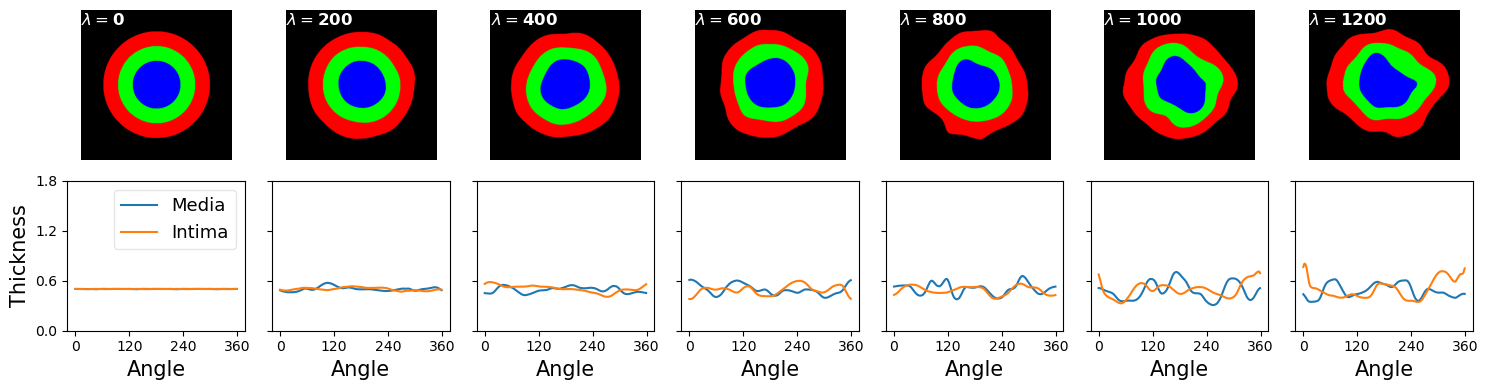

In [6]:
img_full = np.zeros((512, 512, 3), np.uint8)
cv2.circle(img_full, (256, 256), 181, (255, 0, 0), -1)
cv2.circle(img_full, (256, 256), 131, (0, 255, 0), -1)
cv2.circle(img_full, (256, 256), 81, (0, 0, 255), -1)

numerical_validation(img_full)

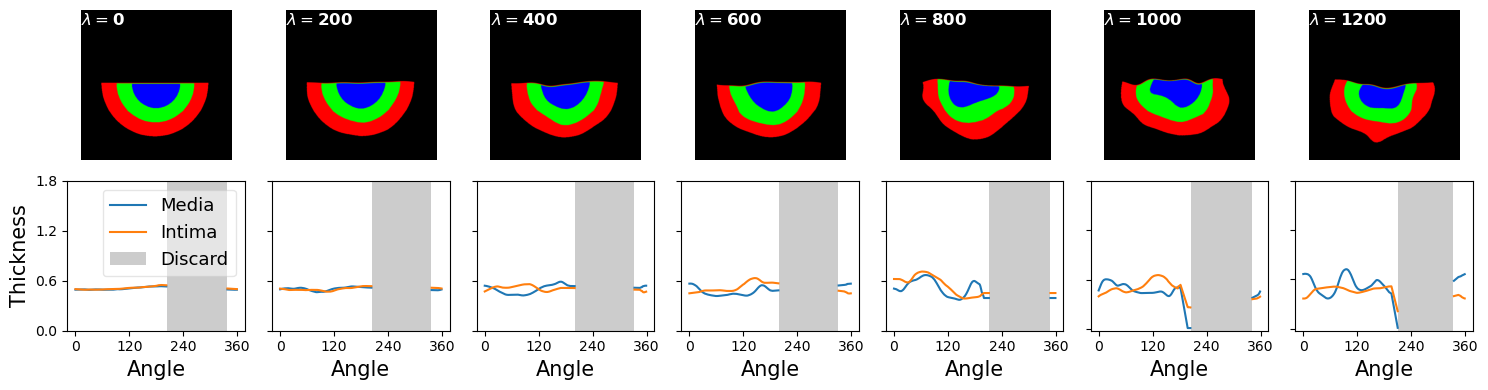

In [7]:
img_edge = np.zeros((512, 512, 3), np.uint8)
cv2.ellipse(img_edge, (250, 250), (181, 181), 0, 0, 180, (255, 0, 0), -1)
cv2.ellipse(img_edge, (252, 252), (131, 131), 0, 0, 180, (0, 255, 0), -1)
cv2.ellipse(img_edge, (254, 254), (81, 81), 0, 0, 180, (0, 0, 255), -1)

numerical_validation(img_edge)

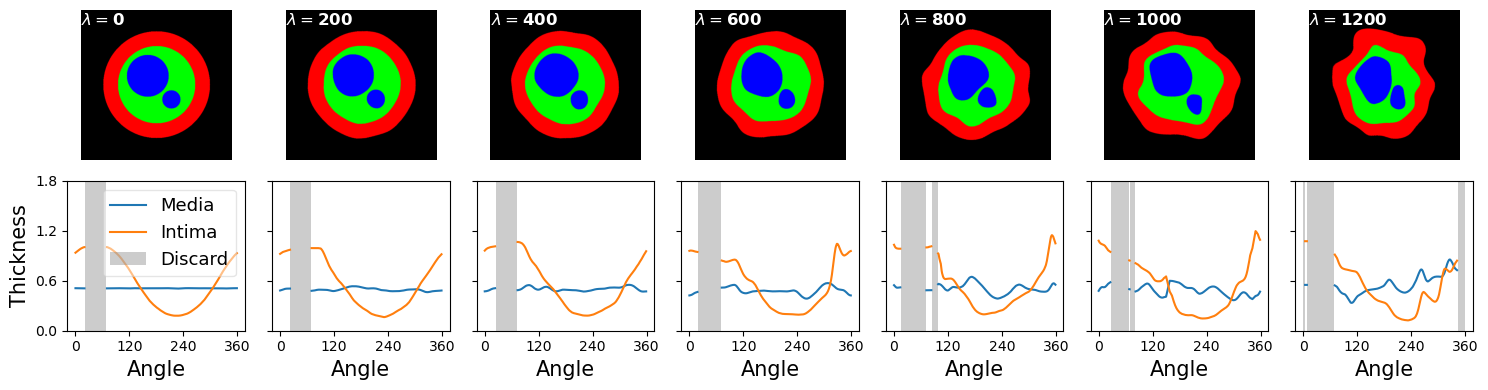

In [8]:
img_multi = np.zeros((512, 512, 3), np.uint8)
cv2.circle(img_multi, (256, 256), 181, (255, 0, 0), -1)
cv2.circle(img_multi, (256, 256), 131, (0, 255, 0), -1)
cv2.circle(img_multi, (226, 226), 71, (0, 0, 255), -1)
cv2.circle(img_multi, (306, 306), 31, (0, 0, 255), -1)

numerical_validation(img_multi)

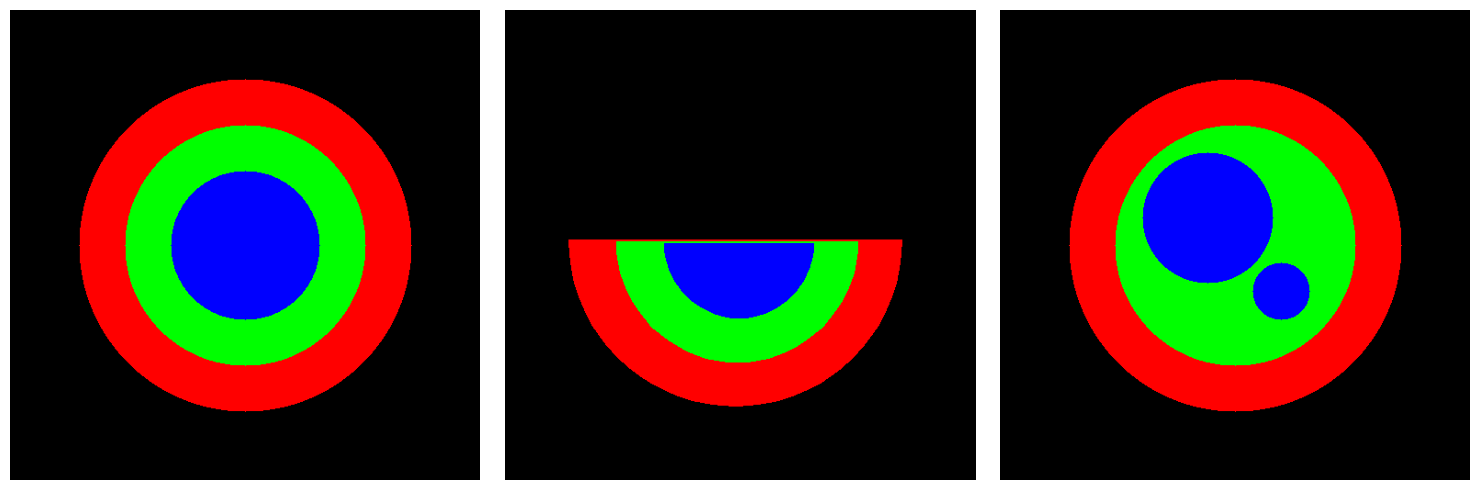

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_full)
axs[0].axis('off')
axs[1].imshow(img_edge)
axs[1].axis('off')
axs[2].imshow(img_multi)
axs[2].axis('off')
plt.tight_layout()
plt.show()